In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import random

d:\Code\Anaconda\envs\japanesename\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
# 完整的日语平假名映射（包括清音、浊音、半浊音、拗音等）
hiragana_list = [
    # 清音
    'あ', 'い', 'う', 'え', 'お',
    'か', 'き', 'く', 'け', 'こ',
    'が', 'ぎ', 'ぐ', 'げ', 'ご',
    'さ', 'し', 'す', 'せ', 'そ',
    'ざ', 'じ', 'ず', 'ぜ', 'ぞ',
    'た', 'ち', 'つ', 'て', 'と',
    'だ', 'ぢ', 'づ', 'で', 'ど',
    'な', 'に', 'ぬ', 'ね', 'の',
    'は', 'ひ', 'ふ', 'へ', 'ほ',
    'ば', 'び', 'ぶ', 'べ', 'ぼ',
    'ぱ', 'ぴ', 'ぷ', 'ぺ', 'ぽ',
    'ま', 'み', 'む', 'め', 'も',
    'や', 'ゆ', 'よ',
    'ら', 'り', 'る', 'れ', 'ろ',
    'わ', 'を', 'ん',
    # 拗音（きゃ、しゃ、ちゃ等）
    'ゃ', 'ゅ', 'ょ',
]

# 创建平假名到整数的映射
hiragana_map = {char: i+1 for i, char in enumerate(hiragana_list)}


hiragana_map["."]=0
hiragana_map["Male"]=75
hiragana_map["Female"]=76
hiragana_map["padding"]=77
hiragana_index_map = {i:char for char, i in hiragana_map.items()}
print(f"总共 {len(hiragana_map)} 个字符")
print(f"映射范围: 0-{len(hiragana_map)-1}")



总共 78 个字符
映射范围: 0-77


In [ ]:
train_df=pd.read_csv("data/gendec-train.csv")
input_df=train_df[["Gender","Hiragana"]]
padding_length=20
min_len=3
tmp=[]
for i in range(len(input_df)):
    tmp.append([0,hiragana_map.get(input_df.iloc[i]['Gender'], 0)]+[hiragana_map.get(char, 0) for char in input_df.iloc[i]['Hiragana']]+[0])
input=[]
for i in range(len(input_df)):
    for j in range(len(tmp[i])-1):
        ix=tmp[i][:j+1]#[76 for _ in range(padding_length-(j+1))]+
        if len(ix)>padding_length:
            ix=ix[-padding_length:]
        iy=tmp[i][j+1]
        input.append([ix, iy])

input[:20]


[[[0], 75],
 [[0, 75], 26],
 [[0, 75, 26], 56],
 [[0, 75, 26, 56], 2],
 [[0, 75, 26, 56, 2], 6],
 [[0, 75, 26, 56, 2, 6], 23],
 [[0, 75, 26, 56, 2, 6, 23], 63],
 [[0, 75, 26, 56, 2, 6, 23, 63], 17],
 [[0, 75, 26, 56, 2, 6, 23, 63, 17], 0],
 [[0], 75],
 [[0, 75], 26],
 [[0, 75, 26], 7],
 [[0, 75, 26, 7], 60],
 [[0, 75, 26, 7, 60], 30],
 [[0, 75, 26, 7, 60, 30], 1],
 [[0, 75, 26, 7, 60, 30, 1], 7],
 [[0, 75, 26, 7, 60, 30, 1, 7], 42],
 [[0, 75, 26, 7, 60, 30, 1, 7, 42], 30],
 [[0, 75, 26, 7, 60, 30, 1, 7, 42, 30], 0],
 [[0], 75]]

In [ ]:
train_df=pd.read_csv("data/gendec-train.csv")
input_df=train_df[["Gender","Hiragana"]]
padding_length=20
min_len=3
tmp=[]
for i in range(len(input_df)):
    tmp.append([0,hiragana_map.get(input_df.iloc[i]['Gender'], 0)]+[hiragana_map.get(char, 0) for char in input_df.iloc[i]['Hiragana']]+[0])

transinput=[]
for i in range(len(input_df)):
    ix=tmp[i][:-1]
    if len(ix)>padding_length:
        ix=ix[-padding_length:]
    iy=tmp[i][1:]
    transinput.append([ix, iy])

transinput[:20]

[[[0, 75, 26, 56, 2, 6, 23, 63, 17], [75, 26, 56, 2, 6, 23, 63, 17, 0]],
 [[0, 75, 26, 7, 60, 30, 1, 7, 42, 30], [75, 26, 7, 60, 30, 1, 7, 42, 30, 0]],
 [[0, 75, 1, 6, 2, 17, 6, 28, 61], [75, 1, 6, 2, 17, 6, 28, 61, 0]],
 [[0, 75, 40, 56, 9, 2, 18, 9], [75, 40, 56, 9, 2, 18, 9, 0]],
 [[0, 75, 7, 8, 26, 56, 16, 42, 68], [75, 7, 8, 26, 56, 16, 42, 68, 0]],
 [[0, 76, 2, 69, 56, 16, 30, 10], [76, 2, 69, 56, 16, 30, 10, 0]],
 [[0, 76, 1, 7, 61, 56, 16, 36, 4], [76, 1, 7, 61, 56, 16, 36, 4, 0]],
 [[0, 75, 40, 19, 56, 16, 42, 68], [75, 40, 19, 56, 16, 42, 68, 0]],
 [[0, 75, 42, 64, 2, 69, 6, 23, 62, 7], [75, 42, 64, 2, 69, 6, 23, 62, 7, 0]],
 [[0, 76, 17, 64, 7, 62, 6], [76, 17, 64, 7, 62, 6, 0]],
 [[0, 76, 3, 18, 31, 1, 7, 10], [76, 3, 18, 31, 1, 7, 10, 0]],
 [[0, 76, 43, 22, 69, 64, 16, 28, 7], [76, 43, 22, 69, 64, 16, 28, 7, 0]],
 [[0, 75, 15, 3, 31, 17, 14, 1, 7], [75, 15, 3, 31, 17, 14, 1, 7, 0]],
 [[0, 75, 60, 65, 2, 10, 3, 18, 9], [75, 60, 65, 2, 10, 3, 18, 9, 0]],
 [[0, 75, 62, 60, 30

In [4]:
# 加载测试集
test_df = pd.read_csv("data/gendec-test.csv")
test_input_df = test_df[["Gender","Hiragana"]]
test_tmp = []
for i in range(len(test_input_df)):
    test_tmp.append([0, hiragana_map.get(test_input_df.iloc[i]['Gender'], 0)] + 
                    [hiragana_map.get(char, 0) for char in test_input_df.iloc[i]['Hiragana']] + [0])

test_transinput = []
for i in range(len(test_input_df)):
    ix = test_tmp[i][:-1]
    if len(ix) > padding_length:
        ix = ix[-padding_length:]
    iy = test_tmp[i][1:]
    test_transinput.append([ix, iy])

print(f"训练集样本数: {len(transinput)}")
print(f"测试集样本数: {len(test_transinput)}")
test_transinput[:5]

训练集样本数: 44897
测试集样本数: 12828


[[[0, 76, 31, 2, 10, 3, 56, 16, 10], [76, 31, 2, 10, 3, 56, 16, 10, 0]],
 [[0, 75, 6, 35, 26, 1, 7, 42, 10], [75, 6, 35, 26, 1, 7, 42, 10, 0]],
 [[0, 75, 26, 9, 41, 64, 26, 6, 40, 65],
  [75, 26, 9, 41, 64, 26, 6, 40, 65, 0]],
 [[0, 75, 17, 17, 35, 1, 28, 42, 16], [75, 17, 17, 35, 1, 28, 42, 16, 0]],
 [[0, 76, 17, 5, 61, 16, 27, 4], [76, 17, 5, 61, 16, 27, 4, 0]]]

In [5]:
def make_batch(input, batch_size, padding_value=77, shuffle_batches=True,trans=True):
    input_sorted = sorted(input, key=lambda x: len(x[0]), reverse=True)
    x_batch = []
    y_batch = []
    for i in range(0, len(input_sorted), batch_size):
        batch = input_sorted[i:i+batch_size]
        ix, iy = zip(*batch)
        max_len = max(len(seq) for seq in ix)
        # print(max_len)
        ix_padded=[]
        if max_len < min_len:
            max_len = min_len
        ix_padded = [[padding_value] * (max_len - len(seq)) + list(seq) for seq in ix]
        
        x_batch.append(ix_padded)
        if trans:
            iy_padded = [[padding_value] * (max_len - len(seq)) + list(seq) for seq in iy]
            y_batch.append(iy_padded)
        else:
            y_batch.append(list(iy))

    if shuffle_batches:
        indices = list(range(len(x_batch)))
        random.shuffle(indices)
        x_batch = [x_batch[i] for i in indices]
        y_batch = [y_batch[i] for i in indices]

    return x_batch, y_batch

batched_input = make_batch(transinput, 32)


In [6]:
batched_input[1][0]
#batched_input[0][-1]

[[76, 43, 66, 41, 17, 36, 5, 57, 0],
 [75, 5, 40, 21, 69, 42, 68, 17, 0],
 [76, 5, 5, 26, 6, 4, 65, 36, 0],
 [76, 42, 64, 17, 56, 62, 3, 7, 0],
 [76, 1, 64, 11, 7, 40, 65, 10, 0],
 [75, 36, 6, 4, 56, 16, 63, 17, 0],
 [76, 2, 69, 7, 65, 4, 65, 6, 0],
 [76, 16, 16, 69, 64, 27, 6, 10, 0],
 [76, 28, 6, 41, 64, 9, 2, 10, 0],
 [75, 3, 4, 31, 10, 3, 18, 9, 0],
 [76, 1, 6, 50, 17, 62, 3, 10, 0],
 [75, 4, 22, 56, 26, 9, 42, 16, 0],
 [76, 36, 11, 63, 17, 16, 8, 64, 0],
 [75, 6, 28, 26, 56, 16, 62, 7, 0],
 [75, 20, 11, 49, 30, 60, 1, 7, 0],
 [76, 61, 56, 15, 4, 6, 5, 66, 0],
 [75, 5, 11, 26, 26, 6, 62, 7, 0],
 [76, 19, 7, 60, 30, 1, 7, 40, 0],
 [75, 2, 40, 56, 26, 9, 71, 22, 0],
 [75, 26, 28, 57, 26, 9, 42, 16, 0],
 [76, 20, 4, 22, 56, 42, 6, 65, 0],
 [76, 63, 39, 8, 64, 16, 30, 57, 0],
 [75, 30, 57, 61, 56, 9, 2, 15, 0],
 [76, 19, 7, 13, 27, 57, 4, 10, 0],
 [75, 5, 5, 16, 69, 9, 2, 15, 0],
 [75, 61, 56, 3, 27, 62, 3, 22, 0],
 [75, 41, 19, 49, 63, 17, 40, 65, 0],
 [75, 26, 9, 40, 8, 37, 42, 68, 0

In [84]:

class BigramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(BigramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.bn = nn.BatchNorm1d(embedding_dim*3)
        self.fc = nn.Linear(embedding_dim*3, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)# B,T,C
        flattened = embedded[:, -3:, :].reshape(embedded.size(0), -1)  # (B, embedding_dim*3)
        #normed = self.bn(flattened)
        output = self.fc(flattened)  # 只使用最后三个时间步的输出进行预测
        return output

In [7]:
class BigramModelPlus(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(BigramModelPlus, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(padding_length, embedding_dim) 
        #self.bn = nn.BatchNorm1d(embedding_dim*4)
        self.fc = nn.Linear(embedding_dim*4, vocab_size)

    def forward(self, x):
        B,T=x.shape
        embedded = self.embedding(x)# B,T,C
        pos_embedding=self.pos_embedding(torch.arange(T, device=embedded.device))  # (T, C)
        tril=torch.tril(torch.ones(embedded.size(1), embedded.size(1))).to(embedded.device)
        tril=tril/tril.sum(dim=1, keepdim=True)  # 归一化，使每行的权重和为1
        mean = torch.matmul(tril, embedded)  # 使用下三角矩阵对嵌入进行加权平均 B,T,C
        embedded = embedded + pos_embedding.unsqueeze(0)  # 添加位置嵌入
        flattened = torch.cat([embedded[:, -3:, :], mean[:, -1:, :]], dim=1).reshape(embedded.size(0), -1)  # (B, embedding_dim*4)
        #normed = self.bn(flattened)
        output = self.fc(flattened)  # 只使用最后三个时间步的输出进行预测
        return output

In [ ]:
class Head(nn.Module):
    def __init__(self, embedding_dim, headsize,dropout=0.1):
        super(Head, self).__init__()
        self.key=nn.Linear(embedding_dim, headsize, bias=False)
        self.query=nn.Linear(embedding_dim, headsize,bias=False)
        self.value=nn.Linear(embedding_dim, headsize,bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(padding_length, padding_length)))
        self.dropout = nn.Dropout(dropout)  # 可选的dropout层
    def forward(self, embedded):
        k=self.key(embedded)  # B,T,headsize
        q=self.query(embedded)  # B,T,headsize
        v=self.value(embedded)  # B,T,headsize
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (k.size(-1) ** 0.5)  # B,T,T

        # 修复掩码：使用下三角矩阵（对角线及下方为1）
        mask = self.tril[:attn_scores.size(1), :attn_scores.size(2)].to(embedded.device)  # 下三角为1
        attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))  # 上三角填充-inf
        attn_weights = F.softmax(attn_scores, dim=-1)  # B,T,T
        attn_weights = self.dropout(attn_weights)  # 应用dropout
        attn_output = torch.matmul(attn_weights, v)  # B,T,headsize
        return attn_output
    
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        headsize = embedding_dim // num_heads
        self.heads = nn.ModuleList([Head(embedding_dim, headsize, dropout) for _ in range(num_heads)])
        self.output_linear = nn.Linear(embedding_dim, embedding_dim)  # 将多头输出映射回embedding_dim
        self.dropout = nn.Dropout(dropout)  # 可选的dropout层
    def forward(self, embedded):
        head_outputs = [head(embedded) for head in self.heads]  # 每个head的输出 B,T,headsize
        concatenated = torch.cat(head_outputs, dim=-1)  # B,T,num_heads*headsize
        output = self.output_linear(concatenated)  # 映射回embedding_dim
        output = self.dropout(output)  # 应用dropout
        return output

class FeedForward(nn.Module):
    def __init__(self,n_emb, dropout=0.1):
        super(FeedForward, self).__init__()
        self.net=nn.Sequential(nn.Linear(n_emb,n_emb*4),
                               nn.ReLU(),
                               nn.Linear(n_emb*4,n_emb),
                            nn.Dropout(dropout)
                               )
        
    def forward(self,x):
        return self.net(x)
class Block(nn.Module):
    def __init__(self, embedding_dim, num_heads,dropout=0.1):
        super(Block, self).__init__()
        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.ff = FeedForward(embedding_dim, dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        attn_output = self.mha(x)  # B,T,embedding_dim
        x = self.norm1(x + attn_output)  # 残差连接 + LayerNorm
        ff_output = self.ff(x)  # B,T,embedding_dim
        x = self.norm2(x + ff_output)  # 残差连接 + LayerNorm
        return x
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim,num_heads=4, dropout=0.1,layers=4):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(padding_length, embedding_dim)  
        
        self.blocks = nn.Sequential(*[Block(embedding_dim, num_heads, dropout) for _ in range(layers)])  # 堆叠多个Transformer块
        self.fc = nn.Linear(embedding_dim, vocab_size)


    def forward(self, x):
        B,T=x.shape
        embedded = self.embedding(x)  # B,T,embedding_dim
        pos_embedding=self.pos_embedding(torch.arange(T, device=embedded.device))  # (T, C)
        embedded = embedded + pos_embedding.unsqueeze(0)  # 添加位置嵌入
        attn_output = self.blocks(embedded)  # B,T,embedding_dim
        output = self.fc(attn_output) # B,T,vocab_size 
        return output

In [43]:
#torch.manual_seed(0)
test_input = torch.tensor(batched_input[0][0][0])  # 输入为一个名字的前缀
test_input = test_input.unsqueeze(0)  # 添加批次维度，变为 (1, T)
print(test_input)
model = TransformerModel(vocab_size=len(hiragana_map), embedding_dim=256,dropout=0.2,num_heads=8,layers=6)
model.eval()
output = model(test_input)
print(output[0,-1,:])
output_index = output[0,-1,:].argmax().item()
print(hiragana_index_map.get(output_index))

tensor([[ 0, 76, 43, 66, 41, 17, 36,  5, 57]])
tensor([ 0.5385,  0.0877,  0.0704, -0.6664, -0.2040, -0.3835,  0.1245,  0.5003,
         0.3452, -0.7985, -0.0777,  0.4950, -0.2212, -0.6435, -0.8863,  0.6121,
         0.0920,  1.3296, -0.6232,  0.1079,  0.1696,  0.4467,  0.1951,  0.2305,
        -0.4101,  0.1383, -0.7494, -0.8864,  0.6194,  0.5754,  0.2148,  0.8084,
         0.5746, -0.1095, -1.0651,  0.4976,  0.2497, -1.2216, -0.7983, -1.0702,
         0.5012, -0.2139, -0.9333, -0.6220, -0.4924, -0.0255, -0.3233, -0.1148,
        -1.4625,  0.1954, -0.3762,  0.9413, -0.0831,  1.1711,  0.6183, -0.2188,
         0.1742, -0.1057,  0.2680, -1.1058, -0.9890, -0.1843, -0.0077, -0.6261,
        -0.0675, -0.4124,  0.3850, -0.2551, -0.9712, -0.5281,  0.2916,  0.4878,
        -0.3419, -0.0249,  0.7756, -0.3144, -0.3560, -0.6208],
       grad_fn=<SelectBackward0>)
し


In [44]:
def evaluate(model, test_input, batch_size=512, padding_value=77):
    """评估模型在测试集上的性能"""
    model.eval()
    device = next(model.parameters()).device
    
    x_batches, y_batches = make_batch(test_input, batch_size, padding_value=padding_value, shuffle_batches=False)
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for ix_batch, iy_batch in zip(x_batches, y_batches):
            ix_tensor = torch.tensor(ix_batch, dtype=torch.long).to(device)
            iy_tensor = torch.tensor(iy_batch, dtype=torch.long).to(device)
            
            output = model(ix_tensor)
            loss = F.cross_entropy(output.view(-1, output.size(-1)), iy_tensor.view(-1))
            total_loss += loss.item()
            
            # 计算准确率
            predictions = output.view(-1, output.size(-1)).argmax(dim=-1)
            total_correct += (predictions == iy_tensor.view(-1)).sum().item()
            total_samples += iy_tensor.numel()
    
    avg_loss = total_loss / len(x_batches)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

def train(model, train_input, test_input=None, epochs=10, lr=0.001, batch_size=512, padding_value=77, save_path=None):
    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"Using device: {device}")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'\n模型总参数量: {total_params:,}')
    print(f'可训练参数量: {trainable_params:,}\n')

    x_batches, y_batches = make_batch(train_input, batch_size, padding_value=padding_value)
    
    # 记录历史loss
    train_losses = []
    test_losses = []
    test_accs = []
    best_test_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for ix_batch, iy_batch in zip(x_batches, y_batches):
            ix_tensor = torch.tensor(ix_batch, dtype=torch.long).to(device)
            iy_tensor = torch.tensor(iy_batch, dtype=torch.long).to(device)

            optimizer.zero_grad()
            output = model(ix_tensor)
            loss = F.cross_entropy(output.view(-1, output.size(-1)), iy_tensor.view(-1))
            
            if torch.isnan(loss):
                print(f"Warning: NaN loss detected at epoch {epoch+1}")
                break
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        train_loss = total_loss / len(x_batches)
        train_losses.append(train_loss)
        
        # 每个 epoch 结束后评估测试集
        if test_input is not None:
            test_loss, test_acc = evaluate(model, test_input, batch_size, padding_value)
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
            
            # 保存最佳模型
            if save_path and test_loss < best_test_loss:
                best_test_loss = test_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'test_loss': test_loss,
                    'test_acc': test_acc,
                }, save_path)
                print(f'  -> Saved best model (test loss: {test_loss:.4f})')
        else:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')
    
    # 训练结束后保存最终模型
    if save_path:
        final_path = save_path.replace('.pth', '_final.pth')
        torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'test_accs': test_accs,
        }, final_path)
        print(f'\n训练完成！最终模型已保存到: {final_path}')
    
    # 训练结束后绘制loss曲线
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    # 绘制loss曲线
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o', markersize=3)
    if test_input is not None:
        plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss', marker='s', markersize=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 绘制准确率曲线（如果有测试集）
    if test_input is not None:
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(test_accs)+1), test_accs, label='Test Accuracy', marker='o', markersize=3, color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Test Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return train_losses, test_losses, test_accs

Using device: cuda

模型总参数量: 4,779,086
可训练参数量: 4,779,086

Epoch 1/100, Train Loss: 2.4894, Test Loss: 2.1585, Test Acc: 0.3877
  -> Saved best model (test loss: 2.1585)
Epoch 2/100, Train Loss: 2.1192, Test Loss: 2.0058, Test Acc: 0.4134
  -> Saved best model (test loss: 2.0058)
Epoch 3/100, Train Loss: 1.9971, Test Loss: 1.9124, Test Acc: 0.4286
  -> Saved best model (test loss: 1.9124)
Epoch 4/100, Train Loss: 1.9159, Test Loss: 1.8466, Test Acc: 0.4391
  -> Saved best model (test loss: 1.8466)
Epoch 5/100, Train Loss: 1.8579, Test Loss: 1.8015, Test Acc: 0.4476
  -> Saved best model (test loss: 1.8015)
Epoch 6/100, Train Loss: 1.8138, Test Loss: 1.7668, Test Acc: 0.4513
  -> Saved best model (test loss: 1.7668)
Epoch 7/100, Train Loss: 1.7801, Test Loss: 1.7403, Test Acc: 0.4562
  -> Saved best model (test loss: 1.7403)
Epoch 8/100, Train Loss: 1.7557, Test Loss: 1.7228, Test Acc: 0.4578
  -> Saved best model (test loss: 1.7228)
Epoch 9/100, Train Loss: 1.7368, Test Loss: 1.7092, Tes

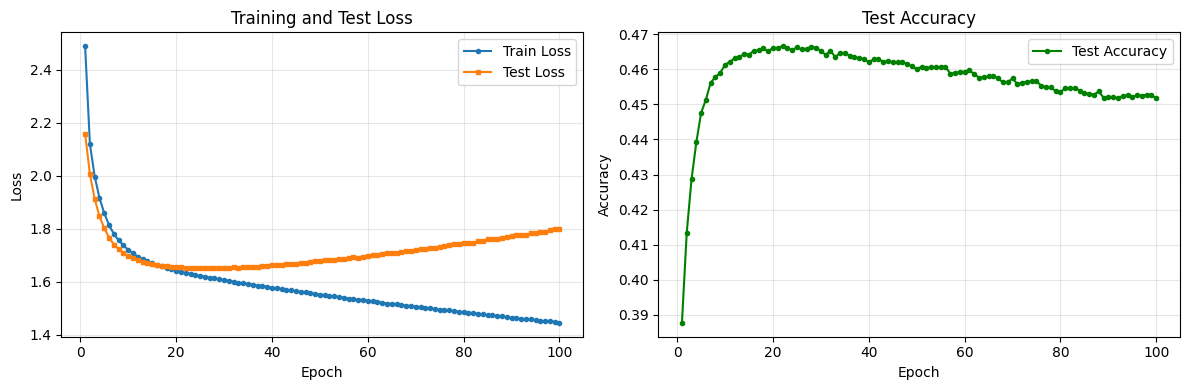

In [45]:
train_losses, test_losses, test_accs = train(model, transinput, test_input=test_transinput, epochs=100, lr=0.0001, batch_size=128, padding_value=hiragana_map["padding"], save_path='best_model.pth')

In [65]:
# 加载保存的模型
def load_model(model, load_path, device=None):
    """加载保存的模型权重"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    checkpoint = torch.load(load_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    print(f"模型已加载自: {load_path}")
    if 'epoch' in checkpoint:
        print(f"Epoch: {checkpoint['epoch']}")
    if 'test_loss' in checkpoint:
        print(f"Test Loss: {checkpoint['test_loss']:.4f}")
    if 'test_acc' in checkpoint:
        print(f"Test Acc: {checkpoint['test_acc']:.4f}")
    
    return model


model = TransformerModel(vocab_size=len(hiragana_map), embedding_dim=256,dropout=0.2,num_heads=8,layers=6)
model = load_model(model, 'best_model.pth')

模型已加载自: best_model.pth
Epoch: 25
Test Loss: 1.6506
Test Acc: 0.4656


In [62]:
sex="Female"
#sex="Male"
prefix="いねだ"  # 输入名字的前缀
test_in=["."]+[sex]+[i for i in prefix]
test_x = [hiragana_map.get(c, 0) for c in test_in] #[0,76,hiragana_map.get("や"),hiragana_map.get("ま"),hiragana_map.get("も"),hiragana_map.get("と")]  # 从一个名字的前缀开始，预测下一个字符
model.eval()  # 设置为评估模式，BatchNorm 使用运行统计
with torch.no_grad():
    while True:
        test_input = torch.tensor(test_x).to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) 
        test_input = test_input.unsqueeze(0)  # 添加批次维度，变为 (1, T)
        #print(test_input)
        output = model(test_input)
        output_index = output[0, -1].argmax().item()
        test_x.append(output_index)
        if output_index==0 or len(test_x)>padding_length:
            break
print("".join([hiragana_index_map.get(i, "") for i in test_x[1:-1]]))

Femaleいねだななこ


Using font: Microsoft YaHei


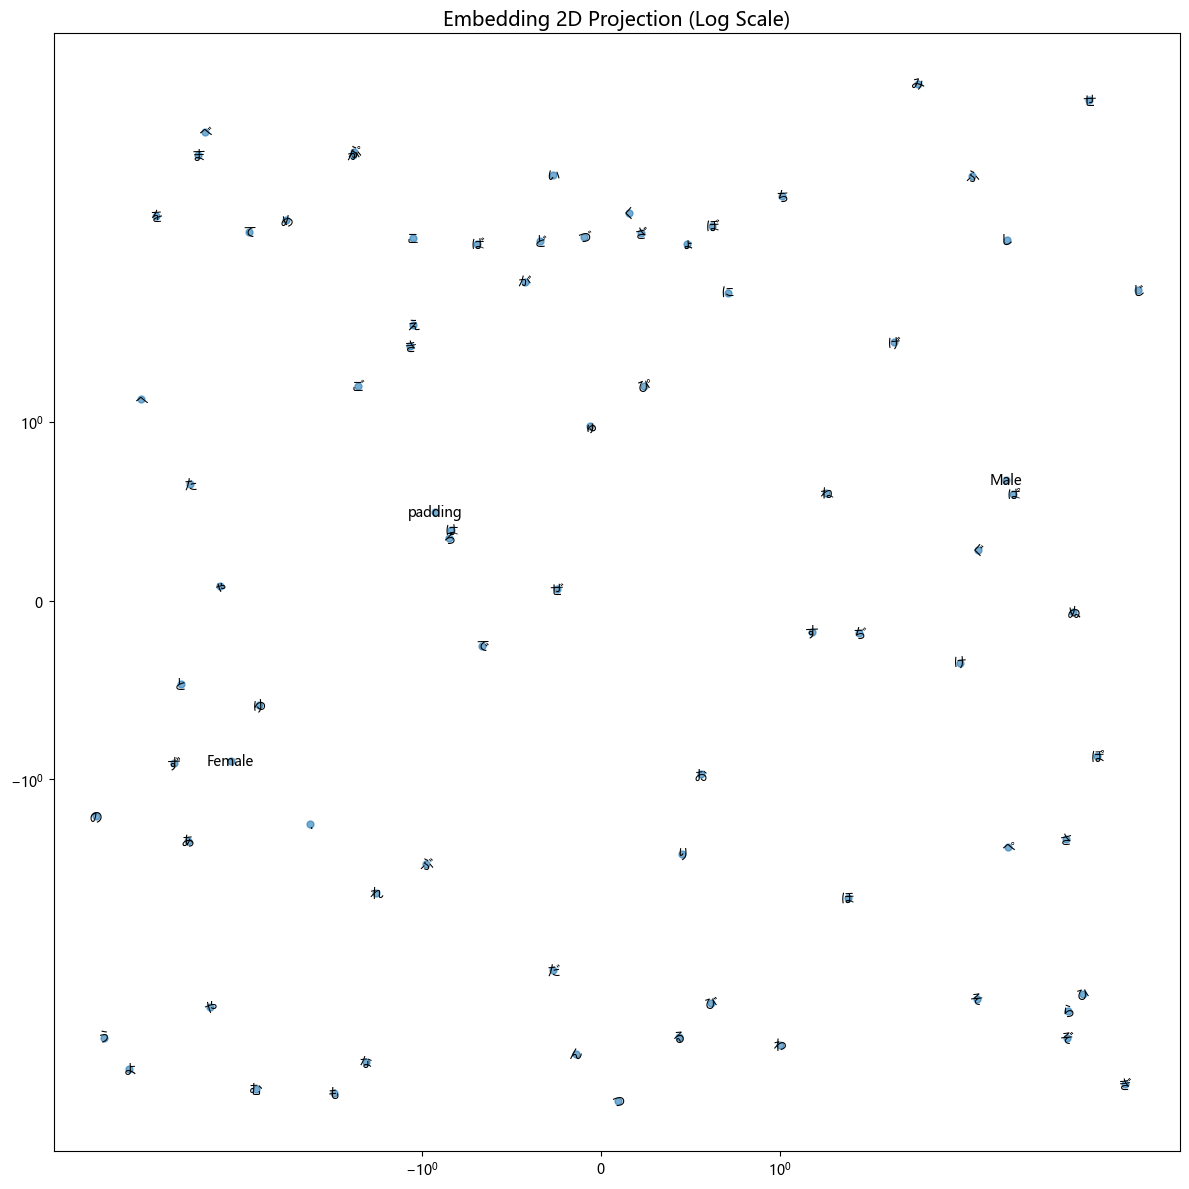

torch.Size([9, 256])


In [63]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 配置 matplotlib 支持日文字体 - 使用系统可用的字体
# Windows 常见字体
font_candidates = [
    'Microsoft YaHei',      # 微软雅黑
    'SimHei',               # 黑体
    'KaiTi',                # 楷体
    'ArialUnicodeMS',       # Arial Unicode MS
    'Yu Gothic',            # Yu Gothic (日文)
    'Hiragino Sans',        # Mac 日文
    'Noto Sans CJK JP',     # Linux 日文
]

# 检查哪个字体可用
available_font = None
for font_name in font_candidates:
    try:
        fm.findfont(font_name)
        available_font = font_name
        print(f"Using font: {available_font}")
        break
    except:
        continue

if available_font:
    plt.rcParams['font.sans-serif'] = [available_font]
else:
    print("Warning: No CJK font found, trying fallback...")
    plt.rcParams['font.sans-serif'] = plt.rcParams['font.sans-serif']  # 使用默认

plt.rcParams['axes.unicode_minus'] = False

# 取出 embedding 权重 (vocab_size, embedding_dim)
with torch.no_grad():
    emb_weight = model.embedding.weight.detach().cpu()

# 用 PCA 将 embedding 降到 2D
try:
    from sklearn.decomposition import PCA
    coords_2d = PCA(n_components=2).fit_transform(emb_weight.numpy())
except Exception:
    # fallback: 使用 torch 自带的 pca
    U, S, V = torch.pca_lowrank(emb_weight, q=2)
    coords_2d = (emb_weight @ V[:, :2]).numpy()

# 可视化：每个 token 一个点
fig, ax = plt.subplots(figsize=(12, 12))
# coords_2d = coords_2d[:6]  # 只可视化我们定义的 token
ax.scatter(coords_2d[:, 0], coords_2d[:, 1], s=25, alpha=0.6)
for idx, (x, y) in enumerate(coords_2d):
    label = hiragana_index_map.get(idx, str(idx))
    # 只显示日文字符，跳过特殊标记
    #if isinstance(label, str) and label not in ['padding', 'Male', 'Female', '.']:
    ax.text(x, y, label, fontsize=10, ha='center', va='center')

ax.set_xscale('symlog')  # 对称对数刻度（可处理正负数）
ax.set_yscale('symlog')
ax.set_title("Embedding 2D Projection (Log Scale)", fontsize=14)
ax.axis("equal")
plt.tight_layout()
plt.show()

# 例子：查看某个输入序列的 embedding（逐 token）
device = next(model.parameters()).device
example_input = torch.tensor(test_x, dtype=torch.long, device=device)
example_emb = model.embedding(example_input).detach().cpu()  # (T, embedding_dim)
print(example_emb.shape)